## Model partition calibration example

In [1]:
%matplotlib inline

import sys

from data_models.parameters import arl_path

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib import pylab as pylab

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame

from processing_library.util.coordinate_support import simulate_point, skycoord_to_lmn

from wrappers.serial.calibration.calibration_control import calibrate_function, create_calibration_controls
from wrappers.serial.skycomponent.operations import find_skycomponents, partition_skycomponent_neighbours

from wrappers.serial.visibility.base import create_blockvisibility, copy_visibility
from processing_library.image.operations import copy_image
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_unittest_components
from wrappers.serial.skycomponent.operations import filter_skycomponents_by_flux
from wrappers.serial.simulation.mpc import create_gaintable_from_screen, sum_visibility_over_partitions, \
    calculate_sf_from_screen
from wrappers.serial.skymodel.operations import show_skymodel

from processing_components.simulation.mpc import expand_skymodel_by_skycomponents

from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits

from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility
from wrappers.arlexecute.skycomponent.operations import insert_skycomponent
from wrappers.arlexecute.image.operations import smooth_image, show_components

from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow
from workflows.serial.imaging.imaging_serial import weight_list_serial_workflow, taper_list_serial_workflow
from workflows.serial.pipelines.pipeline_serial import continuum_imaging_list_serial_workflow, \
    ical_list_serial_workflow

from data_models.data_model_helpers import import_blockvisibility_from_hdf5

from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client

In [2]:
import logging
def init_logging():
    logging.basicConfig(filename='results/low-sims-mpc.log',
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)

init_logging()
log = logging.getLogger()
    
def lprint(*args):
    log.info(*args)
    print(*args)

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 14.0)
pylab.rcParams['image.cmap'] = 'rainbow'

### Read the previously prepared observation: 10 minutes at transit, with 10s integration.

In [10]:
rmax = 10000.0
blockvis = import_blockvisibility_from_hdf5('results/low-sims-mpc-skymodel-noniso-blockvis_rmax10000.0.hdf5')
from data_models.data_model_helpers import import_skycomponent_from_hdf5, import_gaintable_from_hdf5
ical_deconvolved0 = \
    import_image_from_fits('results/low-sims-mpc-noniso-ical-deconvolved_rmax%.1f.fits' % rmax)
gaintable = import_gaintable_from_hdf5('results/low-sims-mpc-noniso-ical-gaintable_rmax%.1f.hdf5' % rmax)
ical_restored=import_image_from_fits('results/low-sims-mpc-noniso-ical-restored_rmax%.1f.fits' % rmax)

In [11]:
nfreqwin = len(blockvis.frequency)
ntimes = len(blockvis.time)
frequency = blockvis.frequency
times = blockvis.time
phasecentre = blockvis.phasecentre

In [17]:
recovered_ical_components = find_skycomponents(ical_restored, fwhm=2, threshold=0.35, npixels=12)
print(len(recovered_ical_components))
print(recovered_ical_components[0])

20
Skycomponent:
	Name: Segment 0
	Flux: [[4.56961174]]
	Frequency: [1.e+08]
	Direction: <SkyCoord (ICRS): (ra, dec) in deg
    (1.50314734, -42.57625927)>
	Shape: Point
	Params: {}
	Polarisation frame: stokesI



### Remove weaker of components that are too close (0.02 rad)

In [18]:
from wrappers.arlexecute.skycomponent.operations import remove_neighbouring_components, voronoi_decomposition
idx, filtered_ical_components = remove_neighbouring_components(recovered_ical_components, 0.01)
print(len(recovered_ical_components))
print(len(filtered_ical_components))
nsources=len(filtered_ical_components)

20
14


In [20]:
vor, vor_array = voronoi_decomposition(ical_restored, filtered_ical_components)
vor_image = copy_image(ical_restored)
vor_image.data[...] = vor_array

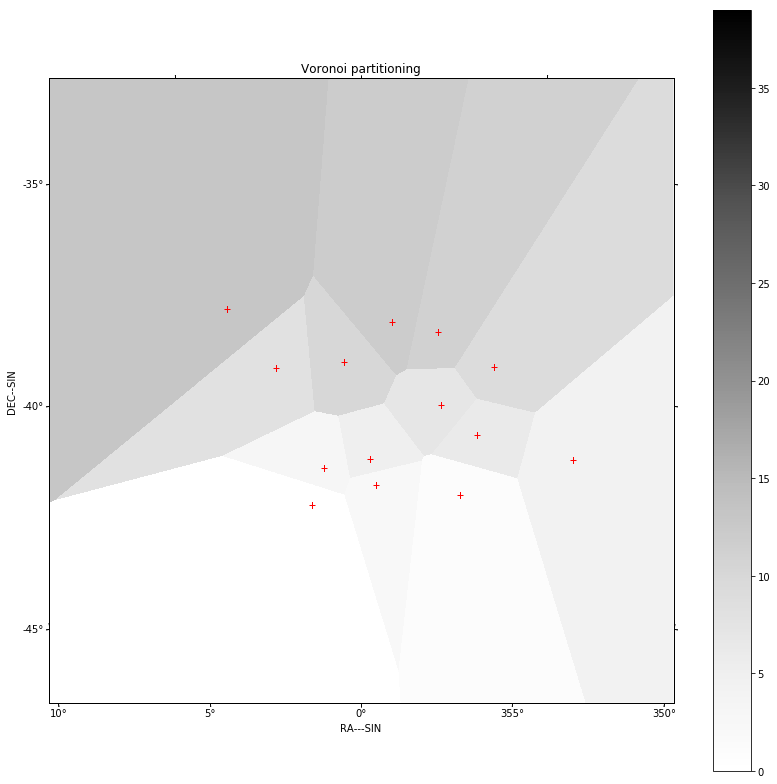

In [21]:
show_image(
    vor_image,
    components=filtered_ical_components,
    cm='Greys',
    title='Voronoi partitioning',
    vmax = 3 * numpy.max(vor_array))

plt.savefig('results/low-sims-mpc-skymodel-voronoi_%dsources_rmax%.1f.jpg' % (nsources, rmax))
plt.show()

### Initialization phase
#### Construct the skymodels, $\theta_p^{(0)}$, based on the Voronoi decomposition of the components. Each skymodel will contain a mask based on the decomposition, an image and gaintable derived from ICAL

In [22]:
iteration=0
from wrappers.arlexecute.skymodel.operations import initialize_skymodel_voronoi
theta_list=initialize_skymodel_voronoi(ical_deconvolved0, filtered_ical_components, gt=gaintable)
from data_models.data_model_helpers import export_skymodel_to_hdf5
export_skymodel_to_hdf5(theta_list, "results/low-sims-mpc-skymodel_%dsources_iteration%d_rmax%.1f.hdf5" % (nsources, iteration, rmax))